<a href="https://colab.research.google.com/github/taravatp/cats_vs_dogs/blob/main/train_pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/cats_vs_dogs/

/content/drive/MyDrive/cats_vs_dogs


In [ ]:
!pip install import_ipynb 

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=28c9e30acabe391a5b5ed21161c8c73ae5f266d83724eeb8a3ac68337d2f7dd8
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb


In [ ]:
import torch
import torch.nn as nn
import import_ipynb
from torchvision import models
import dataset
from torch.utils.data import Dataset,DataLoader
from dataset import vgg_dataset
import time
import numpy as np

In [ ]:
!pip install torch_summary
from torchsummary import summary

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Loading data

In [ ]:
train_root = '/content/drive/MyDrive/cats_vs_dogs/training_set/training_set'
valid_root =  '/content/drive/MyDrive/cats_vs_dogs/test_set/test_set'
train_set = vgg_dataset(dataset_path=train_root)
valid_set = vgg_dataset(dataset_path=valid_root)

batch_size = 32
data_loader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True) 
data_loader_valid = DataLoader(valid_set, batch_size=batch_size, shuffle=True, drop_last=True) 

# defining model - optimizer and loss function

In [ ]:
model = models.vgg16(pretrained=True)
for param in model.parameters():
  param.requires_grad = False
  
model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
model.classifier = nn.Sequential(nn.Flatten(),
                                 nn.Linear(512,128),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(128,1),
                                 nn.Sigmoid())
model = model.to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
loss_function = nn.BCELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

# training and validating

In [ ]:
num_epochs = 5
train_total_loss, train_total_accuracy, valid_total_accuracy= [],[],[]
for epoch in range(num_epochs):
  train_epoch_loss,train_epoch_accuracy,valid_epoch_accuracy=[],[],[] 
  model.train()
  time_start = time.time()

  for iteration,batch in enumerate(iter(data_loader_train)):
    input_image , label = batch
    prediction = model(input_image)
    batch_loss = loss_function(prediction,label)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    train_epoch_loss.append(batch_loss.item())

  for iteration,batch in enumerate(iter(data_loader_train)):
    model.eval()
    input_image , label = batch
    prediction = model(input_image)
    is_correct = ((prediction>0.5) == label).cpu().numpy().tolist()
    train_epoch_accuracy.extend(is_correct)
  
  for iteration,batch in enumerate(iter(data_loader_valid)):
    model.eval()
    input_image , label = batch
    prediction = model(input_image)
    is_correct = ((prediction>0.5) == label).cpu().numpy().tolist()
    valid_epoch_accuracy.extend(is_correct)

  train_total_loss.append(np.array(train_epoch_loss).mean())
  train_total_accuracy.append(np.mean(train_epoch_accuracy))
  valid_total_accuracy.append(np.mean(valid_epoch_accuracy))

  print("Finished epoch[{}], time elapsed[{}]".format(epoch, time.time() - time_start))
  torch.save(model.state_dict(), f"model{epoch}_batch_{batch_size}.pth")


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Finished epoch[0], time elapsed[938.2352731227875]
Finished epoch[1], time elapsed[81.71933317184448]
Finished epoch[2], time elapsed[93.4764986038208]
Finished epoch[3], time elapsed[94.52849340438843]
Finished epoch[4], time elapsed[94.33191394805908]


In [ ]:
print(train_total_loss)
print(train_total_accuracy)
print(valid_total_accuracy)

[0.24638657596322797, 0.053860062432865945, 0.03504667456652368, 0.027549434498312972, 0.02296213992691088]
[0.9788306451612904, 0.9929435483870968, 0.9949596774193549, 0.9979838709677419, 0.998991935483871]
[0.9788306451612904, 0.9919354838709677, 0.9889112903225806, 0.9879032258064516, 0.9848790322580645]


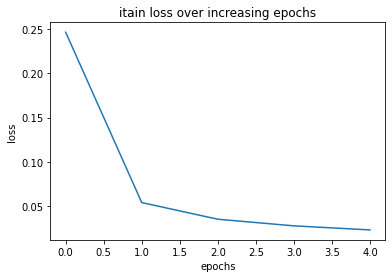

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('itain loss over increasing epochs')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(train_total_loss)

Text(0.5, 1.0, 'validation set accuracy over increasing epochs')

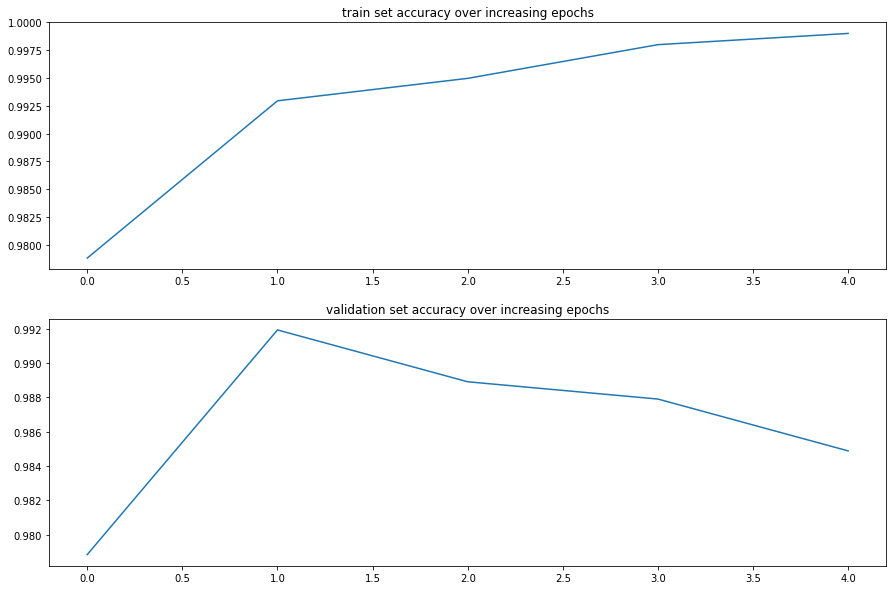

In [ ]:
figure, axis = plt.subplots(2,figsize=(15,10))
axis[0].plot(train_total_accuracy)
axis[0].set_title('train set accuracy over increasing epochs')
axis[1].plot(valid_total_accuracy)
axis[1].set_title('validation set accuracy over increasing epochs')